In [1]:
import csv
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import concatenate, Input
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import pickle
import json

Using TensorFlow backend.


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from jupyterthemes import jtplot
jtplot.style()
sns.set_context("poster")
# plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [3]:
#we want to predict the steering angle for the next second of video. Here we 
#skip each 3 frames and predict on them
num_predict_ahead_frames_to_use = 90
predict_ahead_step_rate = 3
num_predict_ahead_frames = num_predict_ahead_frames_to_use//predict_ahead_step_rate


In [4]:
X_train = []
S_train = []
y_train = []

drives = ['V79_shadow_run_shadow_1.pkl', 'V79_run_office_2_1.pkl']
for drive in drives:
    with open('{}'.format(drive), 'rb') as f:
        data = pickle.load(f,encoding='latin1')
        
    X, S, Y = (data['images'], 
        data['sensors'], 
        data['steering_throttle'].astype(np.float64))
    X_train.extend(X) #images
    S_train.extend(S) #sensors
    y_train.extend(Y) #steering
    
    #flip left to right for augmented data
    X, S, Y = (np.array([np.fliplr(x) for x in data['images']]),
        data['sensors'],
        np.negative(data['steering_throttle'].astype(np.float64)))
               
    X_train.extend(X) #images
    S_train.extend(S) #sensors
    y_train.extend(Y) #steering
    
X_train = np.array(X_train)
S_train = np.array(S_train)
y_train = np.array(y_train)

In [5]:
print(X_train.shape, S_train.shape, y_train.shape)

(44788, 80, 320, 3) (44788, 2) (44788, 30)


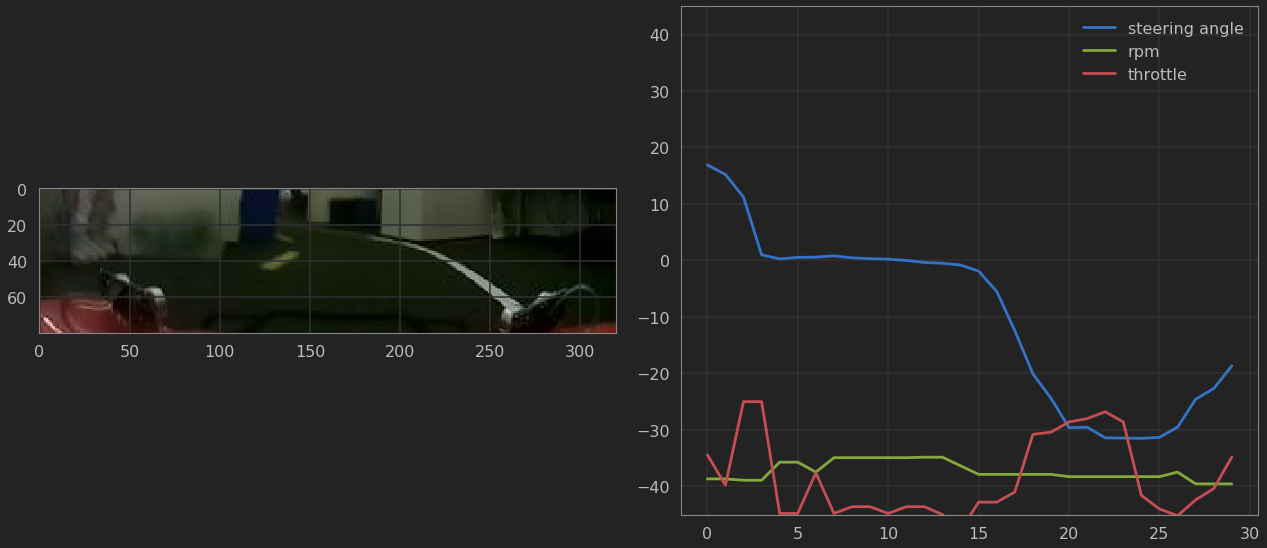

In [6]:
#view some images
frame = 100

plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(X_train[frame])
plt.subplot(122)
plt.plot(y_train[frame] * 45, label="steering angle")
plt.plot(S_train[frame: frame + 90:3, 0] * 100 - 45, label="rpm")
plt.plot(S_train[frame: frame + 90:3, 1] * 100 - 45, label="throttle")
plt.ylim((-45,45))
plt.legend()
plt.tight_layout()
plt.show()


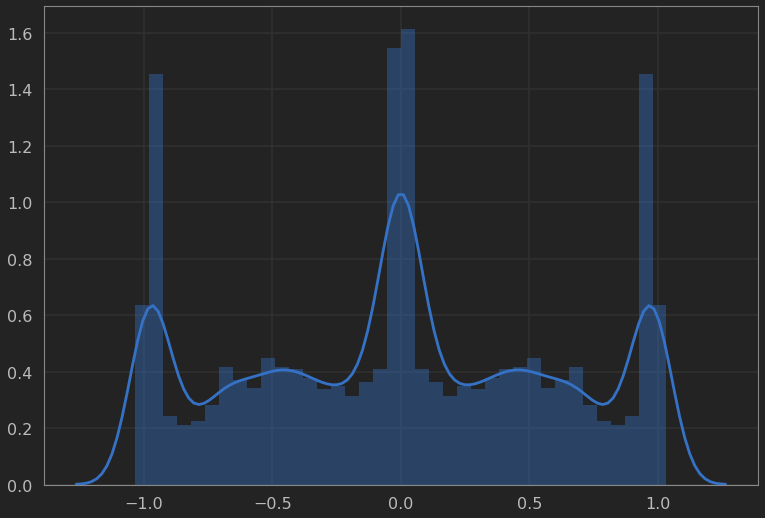

In [7]:
# lets look at the RPM data
sns.distplot(y_train[:,0])

In [8]:
def create_model():
    model = Sequential()
    
    #inputs
    image_input = Input(shape=(80, 320, 3), name='image_input', dtype='float32')
    sensor_input = Input(shape=(1,), name='sensor_input', dtype='float32')
    
    # preprocess
    X = Lambda(lambda x: x/255.0 - 0.5, name="lambda_1")(image_input)
    
    # conv1 layer
    X = Convolution2D(32, (5, 5), name="conv_1")(X)
    X = MaxPooling2D((2, 2), name="pool_1")(X)
    X = Activation('relu',name="relu_1")(X)
    
    # conv2 layer
    X = Convolution2D(64, (5, 5), name="conv_2")(X)
    X = MaxPooling2D((3, 3), name="pool_2")(X)
    X = Activation('relu', name="relu_2")(X)
    
    # conv3 layer
    X = Convolution2D(128, (3, 3), name="conv_3")(X)
    X = MaxPooling2D((2, 2), name="pool_3")(X)
    X = Activation('relu', name="relu_3")(X)

    # conv4 layer
    X = Convolution2D(128, (3, 3), name="conv_4")(X)
    X = MaxPooling2D((2, 2), name="pool_4")(X)
    X = Activation('relu', name="relu_4")(X)

    #add fully connected layers
    X = Flatten(name="flat_1")(X)
    
    #add in the speed, here we may add in other variables such 
    # as the last several throttle / speed/ steering angles, and other sensors
    X = concatenate([X, sensor_input], name="concate_1")
    
    # fc1
    X = Dense(1024, name="dnse_1")(X)
    X = Dropout(0.5, name="dropout_1")(X)
    X = Activation('relu', name="dense_relu_1")(X)
    
    # fc2
    X = Dense(128, name="dnse_2")(X)
    X = Dropout(0.5, name="dropout_2")(X)
    X = Activation('relu', name="dense_relu_2")(X)
    
    # fc2
    X = Dense(64, name="dnse_3")(X)
    X = Dropout(0.5, name="dropout_3")(X)
    X = Activation('relu', name="dense_relu_3")(X)
    
    #outputs are the next 10 frames
    steer_outputs = []
    for i in range(num_predict_ahead_frames):
        steer_output = Dense(1, name='steer_output_{}'.format(i))(X)
        steer_outputs.append(steer_output)
    
    

    #model = Model(inputs=[image_input, sensor_input], outputs=[steer_output, throttle_output])
    model = Model(inputs=[image_input, sensor_input], outputs=steer_outputs)

    loss_def = {"steer_output_{}".format(i) : "mse" for i in range(num_predict_ahead_frames)}
    loss_weight_def = {"steer_output_{}".format(i) : 1.0 for i in range(num_predict_ahead_frames)}
    
    # note, setting the loss weight to favor steering
    model.compile(optimizer='adam', loss=loss_def, loss_weights=loss_weight_def)

    return model

In [9]:
#create the model and save it as json
model = create_model()
with open("model.json", "w") as f:
    json.dump(model.to_json(), f)

In [10]:
#loading the model
from keras.models import model_from_yaml, model_from_json
with open("model.json") as f:
    model = model_from_json(json.load(f))
    model.compile(loss="mse", optimizer="adam")
    model.load_weights("office_set_predict_ahead_90_with_rpm_temp.h5")  #<--last run

In [11]:
y_train.shape

(44788, 30)

In [12]:
y_output = {"steer_output_{}".format(i) : y_train[:,i] for i in range(num_predict_ahead_frames)}

In [13]:
hist = []
for i in range(0,50):
    print("{} --------------".format(i))
    h = model.fit({'image_input': X_train, 'sensor_input': S_train[:,0]}, y_output, 
                  shuffle=True, epochs=10, validation_split=.3, batch_size=128)
    hist.append(h.history)
    with open('history_90.json', 'w') as f:
            json.dump(hist, f)
            
    if i % 2 == 0:
        model.save("office_set_predict_ahead_90_with_rpm_{}.h5".format(i))
    

0 --------------
Train on 31351 samples, validate on 13437 samples
Epoch 1/10
31351/31351 [==============================] - 118s - loss: 1.6338 - steer_output_0_loss: 0.0717 - steer_output_1_loss: 0.0625 - steer_output_2_loss: 0.0561 - steer_output_3_loss: 0.0524 - steer_output_4_loss: 0.0505 - steer_output_5_loss: 0.0498 - steer_output_6_loss: 0.0495 - steer_output_7_loss: 0.0497 - steer_output_8_loss: 0.0498 - steer_output_9_loss: 0.0495 - steer_output_10_loss: 0.0491 - steer_output_11_loss: 0.0485 - steer_output_12_loss: 0.0481 - steer_output_13_loss: 0.0478 - steer_output_14_loss: 0.0479 - steer_output_15_loss: 0.0484 - steer_output_16_loss: 0.0491 - steer_output_17_loss: 0.0502 - steer_output_18_loss: 0.0516 - steer_output_19_loss: 0.0529 - steer_output_20_loss: 0.0534 - steer_output_21_loss: 0.0540 - steer_output_22_loss: 0.0543 - steer_output_23_loss: 0.0547 - steer_output_24_loss: 0.0558 - steer_output_25_loss: 0.0577 - steer_output_26_loss: 0.0605 - steer_output_27_loss: 0.06

31351/31351 [==============================] - 114s - loss: 1.5146 - steer_output_0_loss: 0.0676 - steer_output_1_loss: 0.0593 - steer_output_2_loss: 0.0534 - steer_output_3_loss: 0.0498 - steer_output_4_loss: 0.0481 - steer_output_5_loss: 0.0474 - steer_output_6_loss: 0.0471 - steer_output_7_loss: 0.0471 - steer_output_8_loss: 0.0471 - steer_output_9_loss: 0.0468 - steer_output_10_loss: 0.0466 - steer_output_11_loss: 0.0457 - steer_output_12_loss: 0.0452 - steer_output_13_loss: 0.0447 - steer_output_14_loss: 0.0447 - steer_output_15_loss: 0.0449 - steer_output_16_loss: 0.0455 - steer_output_17_loss: 0.0465 - steer_output_18_loss: 0.0475 - steer_output_19_loss: 0.0483 - steer_output_20_loss: 0.0487 - steer_output_21_loss: 0.0488 - steer_output_22_loss: 0.0488 - steer_output_23_loss: 0.0488 - steer_output_24_loss: 0.0496 - steer_output_25_loss: 0.0515 - steer_output_26_loss: 0.0542 - steer_output_27_loss: 0.0578 - steer_output_28_loss: 0.0631 - steer_output_29_loss: 0.0701 - val_loss: 1

31351/31351 [==============================] - 114s - loss: 1.4628 - steer_output_0_loss: 0.0663 - steer_output_1_loss: 0.0578 - steer_output_2_loss: 0.0522 - steer_output_3_loss: 0.0488 - steer_output_4_loss: 0.0471 - steer_output_5_loss: 0.0463 - steer_output_6_loss: 0.0457 - steer_output_7_loss: 0.0457 - steer_output_8_loss: 0.0456 - steer_output_9_loss: 0.0455 - steer_output_10_loss: 0.0453 - steer_output_11_loss: 0.0445 - steer_output_12_loss: 0.0441 - steer_output_13_loss: 0.0438 - steer_output_14_loss: 0.0438 - steer_output_15_loss: 0.0439 - steer_output_16_loss: 0.0443 - steer_output_17_loss: 0.0448 - steer_output_18_loss: 0.0456 - steer_output_19_loss: 0.0463 - steer_output_20_loss: 0.0466 - steer_output_21_loss: 0.0468 - steer_output_22_loss: 0.0468 - steer_output_23_loss: 0.0468 - steer_output_24_loss: 0.0474 - steer_output_25_loss: 0.0487 - steer_output_26_loss: 0.0510 - steer_output_27_loss: 0.0545 - steer_output_28_loss: 0.0599 - steer_output_29_loss: 0.0667 - val_loss: 1

31351/31351 [==============================] - 113s - loss: 1.4660 - steer_output_0_loss: 0.0654 - steer_output_1_loss: 0.0569 - steer_output_2_loss: 0.0516 - steer_output_3_loss: 0.0484 - steer_output_4_loss: 0.0470 - steer_output_5_loss: 0.0462 - steer_output_6_loss: 0.0460 - steer_output_7_loss: 0.0460 - steer_output_8_loss: 0.0461 - steer_output_9_loss: 0.0459 - steer_output_10_loss: 0.0456 - steer_output_11_loss: 0.0450 - steer_output_12_loss: 0.0446 - steer_output_13_loss: 0.0443 - steer_output_14_loss: 0.0441 - steer_output_15_loss: 0.0441 - steer_output_16_loss: 0.0444 - steer_output_17_loss: 0.0449 - steer_output_18_loss: 0.0456 - steer_output_19_loss: 0.0463 - steer_output_20_loss: 0.0466 - steer_output_21_loss: 0.0467 - steer_output_22_loss: 0.0467 - steer_output_23_loss: 0.0468 - steer_output_24_loss: 0.0475 - steer_output_25_loss: 0.0491 - steer_output_26_loss: 0.0514 - steer_output_27_loss: 0.0550 - steer_output_28_loss: 0.0604 - steer_output_29_loss: 0.0675 - val_loss: 1

31351/31351 [==============================] - 112s - loss: 1.4377 - steer_output_0_loss: 0.0667 - steer_output_1_loss: 0.0580 - steer_output_2_loss: 0.0522 - steer_output_3_loss: 0.0487 - steer_output_4_loss: 0.0468 - steer_output_5_loss: 0.0460 - steer_output_6_loss: 0.0454 - steer_output_7_loss: 0.0453 - steer_output_8_loss: 0.0453 - steer_output_9_loss: 0.0451 - steer_output_10_loss: 0.0448 - steer_output_11_loss: 0.0442 - steer_output_12_loss: 0.0437 - steer_output_13_loss: 0.0432 - steer_output_14_loss: 0.0432 - steer_output_15_loss: 0.0435 - steer_output_16_loss: 0.0437 - steer_output_17_loss: 0.0441 - steer_output_18_loss: 0.0447 - steer_output_19_loss: 0.0449 - steer_output_20_loss: 0.0449 - steer_output_21_loss: 0.0447 - steer_output_22_loss: 0.0447 - steer_output_23_loss: 0.0448 - steer_output_24_loss: 0.0454 - steer_output_25_loss: 0.0471 - steer_output_26_loss: 0.0492 - steer_output_27_loss: 0.0528 - steer_output_28_loss: 0.0586 - steer_output_29_loss: 0.0660 - val_loss: 1

31351/31351 [==============================] - 113s - loss: 1.4136 - steer_output_0_loss: 0.0642 - steer_output_1_loss: 0.0556 - steer_output_2_loss: 0.0501 - steer_output_3_loss: 0.0469 - steer_output_4_loss: 0.0457 - steer_output_5_loss: 0.0453 - steer_output_6_loss: 0.0451 - steer_output_7_loss: 0.0452 - steer_output_8_loss: 0.0455 - steer_output_9_loss: 0.0454 - steer_output_10_loss: 0.0452 - steer_output_11_loss: 0.0443 - steer_output_12_loss: 0.0436 - steer_output_13_loss: 0.0430 - steer_output_14_loss: 0.0427 - steer_output_15_loss: 0.0427 - steer_output_16_loss: 0.0427 - steer_output_17_loss: 0.0429 - steer_output_18_loss: 0.0435 - steer_output_19_loss: 0.0442 - steer_output_20_loss: 0.0444 - steer_output_21_loss: 0.0443 - steer_output_22_loss: 0.0443 - steer_output_23_loss: 0.0442 - steer_output_24_loss: 0.0447 - steer_output_25_loss: 0.0460 - steer_output_26_loss: 0.0483 - steer_output_27_loss: 0.0519 - steer_output_28_loss: 0.0573 - steer_output_29_loss: 0.0643 - val_loss: 1

31351/31351 [==============================] - 113s - loss: 1.4005 - steer_output_0_loss: 0.0636 - steer_output_1_loss: 0.0550 - steer_output_2_loss: 0.0492 - steer_output_3_loss: 0.0460 - steer_output_4_loss: 0.0449 - steer_output_5_loss: 0.0446 - steer_output_6_loss: 0.0445 - steer_output_7_loss: 0.0447 - steer_output_8_loss: 0.0450 - steer_output_9_loss: 0.0448 - steer_output_10_loss: 0.0444 - steer_output_11_loss: 0.0436 - steer_output_12_loss: 0.0431 - steer_output_13_loss: 0.0427 - steer_output_14_loss: 0.0425 - steer_output_15_loss: 0.0424 - steer_output_16_loss: 0.0425 - steer_output_17_loss: 0.0428 - steer_output_18_loss: 0.0433 - steer_output_19_loss: 0.0439 - steer_output_20_loss: 0.0439 - steer_output_21_loss: 0.0438 - steer_output_22_loss: 0.0438 - steer_output_23_loss: 0.0439 - steer_output_24_loss: 0.0445 - steer_output_25_loss: 0.0459 - steer_output_26_loss: 0.0479 - steer_output_27_loss: 0.0515 - steer_output_28_loss: 0.0572 - steer_output_29_loss: 0.0647 - val_loss: 1

31351/31351 [==============================] - 113s - loss: 1.3963 - steer_output_0_loss: 0.0644 - steer_output_1_loss: 0.0559 - steer_output_2_loss: 0.0502 - steer_output_3_loss: 0.0470 - steer_output_4_loss: 0.0452 - steer_output_5_loss: 0.0447 - steer_output_6_loss: 0.0446 - steer_output_7_loss: 0.0446 - steer_output_8_loss: 0.0447 - steer_output_9_loss: 0.0445 - steer_output_10_loss: 0.0441 - steer_output_11_loss: 0.0432 - steer_output_12_loss: 0.0428 - steer_output_13_loss: 0.0426 - steer_output_14_loss: 0.0425 - steer_output_15_loss: 0.0426 - steer_output_16_loss: 0.0425 - steer_output_17_loss: 0.0426 - steer_output_18_loss: 0.0431 - steer_output_19_loss: 0.0433 - steer_output_20_loss: 0.0433 - steer_output_21_loss: 0.0432 - steer_output_22_loss: 0.0433 - steer_output_23_loss: 0.0435 - steer_output_24_loss: 0.0440 - steer_output_25_loss: 0.0453 - steer_output_26_loss: 0.0473 - steer_output_27_loss: 0.0509 - steer_output_28_loss: 0.0566 - steer_output_29_loss: 0.0638 - val_loss: 1

31351/31351 [==============================] - 113s - loss: 1.3919 - steer_output_0_loss: 0.0644 - steer_output_1_loss: 0.0556 - steer_output_2_loss: 0.0496 - steer_output_3_loss: 0.0462 - steer_output_4_loss: 0.0446 - steer_output_5_loss: 0.0442 - steer_output_6_loss: 0.0440 - steer_output_7_loss: 0.0441 - steer_output_8_loss: 0.0442 - steer_output_9_loss: 0.0441 - steer_output_10_loss: 0.0438 - steer_output_11_loss: 0.0431 - steer_output_12_loss: 0.0426 - steer_output_13_loss: 0.0421 - steer_output_14_loss: 0.0421 - steer_output_15_loss: 0.0422 - steer_output_16_loss: 0.0423 - steer_output_17_loss: 0.0427 - steer_output_18_loss: 0.0432 - steer_output_19_loss: 0.0439 - steer_output_20_loss: 0.0440 - steer_output_21_loss: 0.0441 - steer_output_22_loss: 0.0439 - steer_output_23_loss: 0.0439 - steer_output_24_loss: 0.0442 - steer_output_25_loss: 0.0454 - steer_output_26_loss: 0.0473 - steer_output_27_loss: 0.0505 - steer_output_28_loss: 0.0561 - steer_output_29_loss: 0.0632 - val_loss: 1

31351/31351 [==============================] - 112s - loss: 1.3817 - steer_output_0_loss: 0.0642 - steer_output_1_loss: 0.0555 - steer_output_2_loss: 0.0495 - steer_output_3_loss: 0.0462 - steer_output_4_loss: 0.0446 - steer_output_5_loss: 0.0439 - steer_output_6_loss: 0.0438 - steer_output_7_loss: 0.0439 - steer_output_8_loss: 0.0437 - steer_output_9_loss: 0.0433 - steer_output_10_loss: 0.0430 - steer_output_11_loss: 0.0423 - steer_output_12_loss: 0.0418 - steer_output_13_loss: 0.0415 - steer_output_14_loss: 0.0415 - steer_output_15_loss: 0.0418 - steer_output_16_loss: 0.0421 - steer_output_17_loss: 0.0424 - steer_output_18_loss: 0.0430 - steer_output_19_loss: 0.0435 - steer_output_20_loss: 0.0436 - steer_output_21_loss: 0.0434 - steer_output_22_loss: 0.0434 - steer_output_23_loss: 0.0431 - steer_output_24_loss: 0.0435 - steer_output_25_loss: 0.0449 - steer_output_26_loss: 0.0471 - steer_output_27_loss: 0.0508 - steer_output_28_loss: 0.0564 - steer_output_29_loss: 0.0638 - val_loss: 1

31351/31351 [==============================] - 112s - loss: 1.3947 - steer_output_0_loss: 0.0644 - steer_output_1_loss: 0.0557 - steer_output_2_loss: 0.0497 - steer_output_3_loss: 0.0463 - steer_output_4_loss: 0.0449 - steer_output_5_loss: 0.0445 - steer_output_6_loss: 0.0444 - steer_output_7_loss: 0.0444 - steer_output_8_loss: 0.0444 - steer_output_9_loss: 0.0443 - steer_output_10_loss: 0.0440 - steer_output_11_loss: 0.0434 - steer_output_12_loss: 0.0428 - steer_output_13_loss: 0.0422 - steer_output_14_loss: 0.0420 - steer_output_15_loss: 0.0421 - steer_output_16_loss: 0.0424 - steer_output_17_loss: 0.0427 - steer_output_18_loss: 0.0431 - steer_output_19_loss: 0.0434 - steer_output_20_loss: 0.0434 - steer_output_21_loss: 0.0433 - steer_output_22_loss: 0.0433 - steer_output_23_loss: 0.0433 - steer_output_24_loss: 0.0439 - steer_output_25_loss: 0.0453 - steer_output_26_loss: 0.0476 - steer_output_27_loss: 0.0514 - steer_output_28_loss: 0.0574 - steer_output_29_loss: 0.0647 - val_loss: 1

31351/31351 [==============================] - 111s - loss: 1.3778 - steer_output_0_loss: 0.0648 - steer_output_1_loss: 0.0559 - steer_output_2_loss: 0.0501 - steer_output_3_loss: 0.0467 - steer_output_4_loss: 0.0453 - steer_output_5_loss: 0.0448 - steer_output_6_loss: 0.0445 - steer_output_7_loss: 0.0443 - steer_output_8_loss: 0.0442 - steer_output_9_loss: 0.0439 - steer_output_10_loss: 0.0436 - steer_output_11_loss: 0.0426 - steer_output_12_loss: 0.0420 - steer_output_13_loss: 0.0416 - steer_output_14_loss: 0.0415 - steer_output_15_loss: 0.0416 - steer_output_16_loss: 0.0418 - steer_output_17_loss: 0.0421 - steer_output_18_loss: 0.0425 - steer_output_19_loss: 0.0428 - steer_output_20_loss: 0.0429 - steer_output_21_loss: 0.0428 - steer_output_22_loss: 0.0427 - steer_output_23_loss: 0.0426 - steer_output_24_loss: 0.0428 - steer_output_25_loss: 0.0439 - steer_output_26_loss: 0.0459 - steer_output_27_loss: 0.0495 - steer_output_28_loss: 0.0553 - steer_output_29_loss: 0.0629 - val_loss: 1

31351/31351 [==============================] - 112s - loss: 1.3760 - steer_output_0_loss: 0.0647 - steer_output_1_loss: 0.0560 - steer_output_2_loss: 0.0501 - steer_output_3_loss: 0.0469 - steer_output_4_loss: 0.0456 - steer_output_5_loss: 0.0450 - steer_output_6_loss: 0.0445 - steer_output_7_loss: 0.0444 - steer_output_8_loss: 0.0444 - steer_output_9_loss: 0.0439 - steer_output_10_loss: 0.0433 - steer_output_11_loss: 0.0425 - steer_output_12_loss: 0.0420 - steer_output_13_loss: 0.0415 - steer_output_14_loss: 0.0413 - steer_output_15_loss: 0.0412 - steer_output_16_loss: 0.0411 - steer_output_17_loss: 0.0413 - steer_output_18_loss: 0.0419 - steer_output_19_loss: 0.0421 - steer_output_20_loss: 0.0422 - steer_output_21_loss: 0.0422 - steer_output_22_loss: 0.0423 - steer_output_23_loss: 0.0424 - steer_output_24_loss: 0.0430 - steer_output_25_loss: 0.0442 - steer_output_26_loss: 0.0464 - steer_output_27_loss: 0.0503 - steer_output_28_loss: 0.0559 - steer_output_29_loss: 0.0633 - val_loss: 1

31351/31351 [==============================] - 112s - loss: 1.3672 - steer_output_0_loss: 0.0635 - steer_output_1_loss: 0.0548 - steer_output_2_loss: 0.0490 - steer_output_3_loss: 0.0459 - steer_output_4_loss: 0.0443 - steer_output_5_loss: 0.0437 - steer_output_6_loss: 0.0434 - steer_output_7_loss: 0.0433 - steer_output_8_loss: 0.0432 - steer_output_9_loss: 0.0431 - steer_output_10_loss: 0.0429 - steer_output_11_loss: 0.0425 - steer_output_12_loss: 0.0422 - steer_output_13_loss: 0.0420 - steer_output_14_loss: 0.0417 - steer_output_15_loss: 0.0417 - steer_output_16_loss: 0.0417 - steer_output_17_loss: 0.0419 - steer_output_18_loss: 0.0423 - steer_output_19_loss: 0.0428 - steer_output_20_loss: 0.0427 - steer_output_21_loss: 0.0427 - steer_output_22_loss: 0.0426 - steer_output_23_loss: 0.0426 - steer_output_24_loss: 0.0431 - steer_output_25_loss: 0.0443 - steer_output_26_loss: 0.0463 - steer_output_27_loss: 0.0497 - steer_output_28_loss: 0.0552 - steer_output_29_loss: 0.0623 - val_loss: 1

31351/31351 [==============================] - 112s - loss: 1.3487 - steer_output_0_loss: 0.0628 - steer_output_1_loss: 0.0541 - steer_output_2_loss: 0.0483 - steer_output_3_loss: 0.0452 - steer_output_4_loss: 0.0441 - steer_output_5_loss: 0.0438 - steer_output_6_loss: 0.0436 - steer_output_7_loss: 0.0435 - steer_output_8_loss: 0.0434 - steer_output_9_loss: 0.0431 - steer_output_10_loss: 0.0427 - steer_output_11_loss: 0.0420 - steer_output_12_loss: 0.0416 - steer_output_13_loss: 0.0415 - steer_output_14_loss: 0.0410 - steer_output_15_loss: 0.0410 - steer_output_16_loss: 0.0410 - steer_output_17_loss: 0.0413 - steer_output_18_loss: 0.0416 - steer_output_19_loss: 0.0419 - steer_output_20_loss: 0.0417 - steer_output_21_loss: 0.0415 - steer_output_22_loss: 0.0413 - steer_output_23_loss: 0.0415 - steer_output_24_loss: 0.0420 - steer_output_25_loss: 0.0432 - steer_output_26_loss: 0.0453 - steer_output_27_loss: 0.0487 - steer_output_28_loss: 0.0541 - steer_output_29_loss: 0.0616 - val_loss: 1

31351/31351 [==============================] - 111s - loss: 1.3715 - steer_output_0_loss: 0.0637 - steer_output_1_loss: 0.0550 - steer_output_2_loss: 0.0493 - steer_output_3_loss: 0.0462 - steer_output_4_loss: 0.0448 - steer_output_5_loss: 0.0441 - steer_output_6_loss: 0.0440 - steer_output_7_loss: 0.0438 - steer_output_8_loss: 0.0437 - steer_output_9_loss: 0.0435 - steer_output_10_loss: 0.0433 - steer_output_11_loss: 0.0426 - steer_output_12_loss: 0.0422 - steer_output_13_loss: 0.0418 - steer_output_14_loss: 0.0418 - steer_output_15_loss: 0.0420 - steer_output_16_loss: 0.0420 - steer_output_17_loss: 0.0422 - steer_output_18_loss: 0.0427 - steer_output_19_loss: 0.0429 - steer_output_20_loss: 0.0428 - steer_output_21_loss: 0.0425 - steer_output_22_loss: 0.0424 - steer_output_23_loss: 0.0424 - steer_output_24_loss: 0.0427 - steer_output_25_loss: 0.0439 - steer_output_26_loss: 0.0460 - steer_output_27_loss: 0.0496 - steer_output_28_loss: 0.0552 - steer_output_29_loss: 0.0625 - val_loss: 1

31351/31351 [==============================] - 112s - loss: 1.3653 - steer_output_0_loss: 0.0637 - steer_output_1_loss: 0.0548 - steer_output_2_loss: 0.0487 - steer_output_3_loss: 0.0453 - steer_output_4_loss: 0.0440 - steer_output_5_loss: 0.0436 - steer_output_6_loss: 0.0434 - steer_output_7_loss: 0.0434 - steer_output_8_loss: 0.0433 - steer_output_9_loss: 0.0431 - steer_output_10_loss: 0.0427 - steer_output_11_loss: 0.0422 - steer_output_12_loss: 0.0417 - steer_output_13_loss: 0.0412 - steer_output_14_loss: 0.0412 - steer_output_15_loss: 0.0416 - steer_output_16_loss: 0.0417 - steer_output_17_loss: 0.0418 - steer_output_18_loss: 0.0421 - steer_output_19_loss: 0.0424 - steer_output_20_loss: 0.0425 - steer_output_21_loss: 0.0423 - steer_output_22_loss: 0.0424 - steer_output_23_loss: 0.0426 - steer_output_24_loss: 0.0432 - steer_output_25_loss: 0.0443 - steer_output_26_loss: 0.0465 - steer_output_27_loss: 0.0502 - steer_output_28_loss: 0.0559 - steer_output_29_loss: 0.0635 - val_loss: 1

31351/31351 [==============================] - 111s - loss: 1.3625 - steer_output_0_loss: 0.0641 - steer_output_1_loss: 0.0550 - steer_output_2_loss: 0.0491 - steer_output_3_loss: 0.0458 - steer_output_4_loss: 0.0441 - steer_output_5_loss: 0.0438 - steer_output_6_loss: 0.0436 - steer_output_7_loss: 0.0435 - steer_output_8_loss: 0.0434 - steer_output_9_loss: 0.0429 - steer_output_10_loss: 0.0425 - steer_output_11_loss: 0.0417 - steer_output_12_loss: 0.0413 - steer_output_13_loss: 0.0412 - steer_output_14_loss: 0.0410 - steer_output_15_loss: 0.0411 - steer_output_16_loss: 0.0413 - steer_output_17_loss: 0.0414 - steer_output_18_loss: 0.0417 - steer_output_19_loss: 0.0422 - steer_output_20_loss: 0.0423 - steer_output_21_loss: 0.0422 - steer_output_22_loss: 0.0422 - steer_output_23_loss: 0.0424 - steer_output_24_loss: 0.0429 - steer_output_25_loss: 0.0440 - steer_output_26_loss: 0.0464 - steer_output_27_loss: 0.0501 - steer_output_28_loss: 0.0559 - steer_output_29_loss: 0.0633 - val_loss: 1

31351/31351 [==============================] - 112s - loss: 1.3576 - steer_output_0_loss: 0.0643 - steer_output_1_loss: 0.0550 - steer_output_2_loss: 0.0491 - steer_output_3_loss: 0.0457 - steer_output_4_loss: 0.0441 - steer_output_5_loss: 0.0433 - steer_output_6_loss: 0.0432 - steer_output_7_loss: 0.0432 - steer_output_8_loss: 0.0430 - steer_output_9_loss: 0.0427 - steer_output_10_loss: 0.0424 - steer_output_11_loss: 0.0417 - steer_output_12_loss: 0.0415 - steer_output_13_loss: 0.0413 - steer_output_14_loss: 0.0413 - steer_output_15_loss: 0.0415 - steer_output_16_loss: 0.0415 - steer_output_17_loss: 0.0417 - steer_output_18_loss: 0.0421 - steer_output_19_loss: 0.0423 - steer_output_20_loss: 0.0424 - steer_output_21_loss: 0.0424 - steer_output_22_loss: 0.0423 - steer_output_23_loss: 0.0423 - steer_output_24_loss: 0.0426 - steer_output_25_loss: 0.0436 - steer_output_26_loss: 0.0455 - steer_output_27_loss: 0.0489 - steer_output_28_loss: 0.0546 - steer_output_29_loss: 0.0621 - val_loss: 1

KeyboardInterrupt: 

In [14]:
model.save("office_set_predict_ahead_90_with_rpm_temp.h5")


In [ ]:
predicted = np.array(model.predict({'image_input': X_train, 'sensor_input': S_train[:,0]}))

In [ ]:
predicted.shape


In [ ]:
# visual actual vs predicted
plt.figure(figsize=(400,10))
plt.plot(y_train, label="train")
plt.plot(predicted[0, :,0], label="predicted")
plt.legend()
plt.xticks(np.arange(0,len(X_train), 1000))
plt.show()

In [ ]:
#inference
frame = 5305


img = X_train[frame]
actual = yy_train[frame] * 45
predicted_angle = [x[frame][0] * 45 for x in predicted]


plt.subplot(211)
plt.imshow(X_train[frame])
plt.subplot(212)
plt.plot(np.arange(0,90,3),actual, label="actual")
plt.plot(np.arange(0,90,3),predicted_angle,  label="predicted")
plt.plot(np.arange(0,90,3),S_train[frame: frame + 90:3, 0] * 500 - 45, label="rpm")
plt.ylim((-45,45))
plt.legend()
plt.title("predicted vs actual steering angle for the next \n30frames (1second at 60fps) @ {} RPM".format(S_train[frame][0] * 5000))
plt.show()

print(yy_train[frame])